In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from scipy import stats
import os
from matplotlib.colors import ListedColormap, Normalize

### Description
________
This script reads the BME scores at each catchment, the variance decomposition of each gauge, the shapefile, and the CAMELS-SPAT catchment attributes to output benchmark ensemble plots based on these decompositions

In [2]:
# Read the variance decomposition csv
df_bm = pd.read_csv('../camels-spat/02_results/skill_scores/benchmark_variance_all.csv', index_col=0)
df_bm.index = df_bm.index.str.replace('_BM\\.csv$', '', regex=True)

# Read the shapefile
border_path = '../camels-spat/politicalboundaries_shapefile/NA_PoliticalDivisions/simplified/simplified_boundaries_15km.shp'

# Read the skill scores
skill_scores = pd.read_csv('../camels-spat/02_results/skill_scores/nse_skill_scores_rank_001.csv', index_col=0)

# Define settings
period= 'validation'
output_dir = '../camels-spat/02_results/nse_plots/'
plot_prefix = 'benchmark_variance'

# CAMELS-SPAT Attributes
attributes = pd.read_csv('../camels-spat/attributes-lumped.csv', low_memory=False)

### Pre Processing

In [3]:
def categorize_catchments_by_variance(df):
    """Categorize catchments by dominant variance component"""
    df_cat = df.copy()
    
    # Get dominant variance for each catchment
    catchment_variance = df_cat.groupby('catchment')[
        ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    ].first()
    
    catchment_variance['dominant_variance'] = catchment_variance.idxmax(axis=1)
    catchment_variance['dominant_variance'] = (
        catchment_variance['dominant_variance']
        .str.replace('obs_', '')
        .str.replace('_var', '')
    )
    
    # Merge back to main dataframe
    df_cat = df_cat.merge(
        catchment_variance[['dominant_variance']], 
        left_on='catchment', 
        right_index=True
    )
    
    return df_cat

In [4]:
# Get all attribute names
all_attributes = attributes['Attribute'].tolist()

# Filter out:
# 1. Attributes with "month" in the name
# 2. Attributes with depth ranges like "0-5cm", "30-60cm", etc.
filtered_attributes = [
    attr for attr in all_attributes 
    if 'month' not in attr.lower() 
    and not any(x in attr for x in ['_0-5cm', '_5-15cm', '_15-30cm', '_30-60cm', 
                                      '_60-100cm', '_100-200cm', '_0cm', '_5cm', 
                                      '_15cm', '_30cm', '_60cm', '_100cm', '_200cm'])
]

# Also exclude metadata columns
metadata_attrs = ['num_years_rdrs', 'num_years_hyd']
filtered_attributes = [attr for attr in filtered_attributes if attr not in metadata_attrs]

print(f"Total attributes in original file: {len(all_attributes)}")
print(f"Attributes after filtering: {len(filtered_attributes)}")
print(f"Attributes removed: {len(all_attributes) - len(filtered_attributes)}")

# Filter the attributes dataframe to keep only these rows
attributes_filtered = attributes[attributes['Attribute'].isin(filtered_attributes)].copy()

print(f"\nFiltered attributes DataFrame shape: {attributes_filtered.shape}")

# Create the catchment_attrs dataframe (transposed for merging with other data)
catchment_attrs = attributes_filtered.set_index('Attribute').T
catchment_attrs.index.name = 'catchment'
catchment_attrs = catchment_attrs.reset_index()

# Convert all columns to numeric (except catchment ID)
for col in catchment_attrs.columns:
    if col != 'catchment':
        catchment_attrs[col] = pd.to_numeric(catchment_attrs[col], errors='coerce')

print(f"\nCatchment attributes DataFrame shape: {catchment_attrs.shape}")
print(f"Number of catchments: {len(catchment_attrs)}")
print(f"Number of attributes per catchment: {len(catchment_attrs.columns) - 1}")


# # Show the available attributes
# print(f"\nAvailable attributes ({len(filtered_attributes)}):")
# for i, attr in enumerate(sorted(filtered_attributes), 1):
#     print(f"  {i:3d}. {attr}")

Total attributes in original file: 1178
Attributes after filtering: 217
Attributes removed: 961

Filtered attributes DataFrame shape: (217, 1430)

Catchment attributes DataFrame shape: (1429, 218)
Number of catchments: 1429
Number of attributes per catchment: 217


In [5]:
# # Add this diagnostic code before the merge
# print("\n" + "="*80)
# print("CHECKING CATCHMENT MATCH BETWEEN DATASETS")
# print("="*80)

# catchments_in_period = set(df['catchment'].unique())
# catchments_in_attrs = set(catchment_attrs['catchment'].unique())

# missing_in_attrs = catchments_in_period - catchments_in_attrs
# missing_in_period = catchments_in_attrs - catchments_in_period

# print(f"\nCatchments in df_period: {len(catchments_in_period)}")
# print(f"Catchments in catchment_attrs: {len(catchments_in_attrs)}")
# print(f"\nCatchments in df_period but NOT in catchment_attrs: {len(missing_in_attrs)}")
# if missing_in_attrs:
#     print(f"Missing catchments: {sorted(missing_in_attrs)}")

# print(f"\nCatchments in catchment_attrs but NOT in df_period: {len(missing_in_period)}")

In [6]:
cols_to_add = ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']

# Collapse df_obs so each catchment appears once
df_obs_single = df_bm[cols_to_add].groupby(level=0).first()

# Now join safely
df_merged = skill_scores.join(df_obs_single, how='left')

# Drop rows with missing skill_score (or missing obs_seasonal_var just to be safe)
df = df_merged.dropna(subset=['skill_score', 'obs_seasonal_var']).copy()

df = df.reset_index()
df = df.rename(columns={'index': 'catchment'})

# Filter for desired period
df_period = df[df['period'] == period].copy()

# Categorize catchments by dominant variance
df_period = categorize_catchments_by_variance(df_period)

# merge attributes onto skill scores
df_merged = df_period.merge(catchment_attrs, on='catchment', how='left')


### Spatial Plot

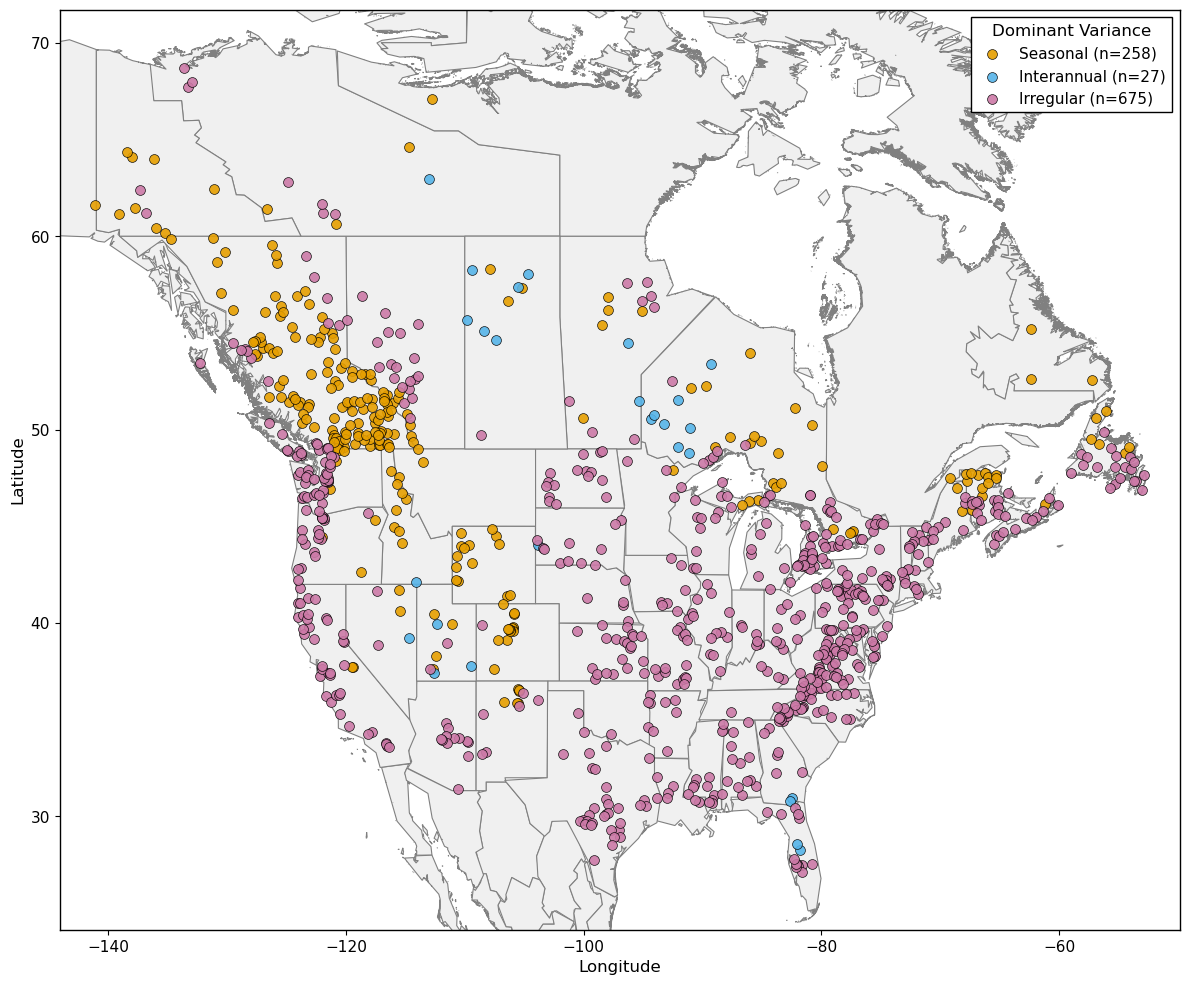


✓ Map saved to ../camels-spat/02_results/nse_plots//benchmark_variance_dominant_variance_map.[png/pdf]

Catchment counts by dominant variance (unique catchments):
dominant_variance
irregular      675
seasonal       258
interannual     27
Name: count, dtype: int64


In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
gdf_borders = gpd.read_file(border_path)

# Reproject to EPSG:4326 if needed
if gdf_borders.crs != "EPSG:4326":
    gdf_borders = gdf_borders.to_crs("EPSG:4326")

# Get unique catchment info from df_bm (one row per catchment)
df_catchments = df_bm.groupby('csv_file').first().reset_index()
df_catchments['catchment'] = df_catchments['csv_file'].str.replace('_BM\\.csv$', '', regex=True)

# Get lat/lon from skill_scores
skill_scores_reset = skill_scores.reset_index()
catchment_col = skill_scores_reset.columns[0]
catchment_locs = skill_scores_reset[[catchment_col, 'latitude', 'longitude']].rename(columns={catchment_col: 'catchment'})

# Get unique locations per catchment (in case of duplicates)
catchment_locs = catchment_locs.groupby('catchment')[['latitude', 'longitude']].first().reset_index()

# Merge location data
df_plot = df_catchments.merge(catchment_locs, on='catchment', how='inner')

# Determine dominant variance using argmax
variance_cols = ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
df_plot['dominant_variance'] = df_plot[variance_cols].idxmax(axis=1)
df_plot['dominant_variance'] = df_plot['dominant_variance'].str.replace('obs_', '').str.replace('_var', '')

# Get unique catchments only (one row per catchment)
df_plot_unique = df_plot.drop_duplicates(subset='catchment')

# --- Check if there's data
if df_plot_unique.empty:
    print("⚠️ No data found.")
else:
    # --- Trim extent with buffer
    lon_min, lon_max = df_plot_unique['longitude'].min() - 3, df_plot_unique['longitude'].max() + 3
    lat_min, lat_max = df_plot_unique['latitude'].min() - 3, df_plot_unique['latitude'].max() + 3
    
    # --- Filter borders shapefile to bbox
    gdf_trim = gdf_borders[
        (gdf_borders.geometry.bounds.minx <= lon_max) &
        (gdf_borders.geometry.bounds.maxx >= lon_min) &
        (gdf_borders.geometry.bounds.miny <= lat_max) &
        (gdf_borders.geometry.bounds.maxy >= lat_min)
    ]
    
    # --- Square figure (matching reference dimensions)
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # --- Plot trimmed borders (matching reference style)
    gdf_trim.plot(ax=ax, facecolor='#f0f0f0', edgecolor='grey', linewidth=0.8)
    
    # --- Set extent
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    
    # --- Define colors for each variance type
    colors = {
        'seasonal': '#E69F00',      # Orange
        'interannual': '#56B4E9',   # Light blue
        'irregular': '#CC79A7'      # Pink/purple
    }
    
    # --- Plot catchments colored by dominant variance
    for var_type in ['seasonal', 'interannual', 'irregular']:
        data = df_plot_unique[df_plot_unique['dominant_variance'] == var_type]
        if len(data) > 0:
            ax.scatter(
                data['longitude'], data['latitude'],
                c=colors[var_type],
                s=50,
                edgecolor='k',
                linewidths=0.5,
                alpha=0.9,  # Increased alpha for sharper appearance
                label=var_type.capitalize(),
                zorder=3,
                rasterized=False  # Ensure vector output for crisp rendering
            )
    
    # --- Format axes (matching reference style)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.tick_params(labelsize=11)
    
    # No gridlines for cleaner look
    ax.grid(False)
    
    # Box around plot (matching reference)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_edgecolor('black')
    
    # --- Add legend to upper right with box (matching reference)
    legend = ax.legend(title='Dominant Variance', loc='upper right',
                      frameon=True, framealpha=1.0, fontsize=11, 
                      title_fontsize=12, edgecolor='black', 
                      fancybox=False, shadow=False)
    legend.get_frame().set_linewidth(1.0)
    
    # Add counts to legend - using unique catchments
    for var_type, text in zip(['seasonal', 'interannual', 'irregular'], legend.get_texts()):
        count = (df_plot_unique['dominant_variance'] == var_type).sum()
        if count > 0:
            text.set_text(f'{text.get_text()} (n={count})')
    
    plt.tight_layout()
    
    # --- Save + show
    plt.savefig(f'{output_dir}/dominant_variance_map.png',
                dpi=300, bbox_inches='tight')
    plt.savefig(f'{output_dir}/dominant_variance_map.pdf',
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    print(f"\n✓ Map saved to {output_dir}/{plot_prefix}_dominant_variance_map.[png/pdf]")
    print(f"\nCatchment counts by dominant variance (unique catchments):")
    print(df_plot_unique['dominant_variance'].value_counts())

### Correlation Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# ============================================================================
# Helper Functions
# ============================================================================

def format_benchmark_name(benchmark_name, max_length=35):
    """Format benchmark names for display with category prefixes and line breaks"""
    categories = {
        'Flow': [
            "bm_mean_flow", "bm_median_flow",
            "bm_monthly_mean_flow", "bm_monthly_median_flow",
            "bm_daily_mean_flow", "bm_daily_median_flow", "bm_eckhardt_baseflow"
        ],
        'Rainfall Runoff': [
            "bm_rainfall_runoff_ratio_to_all",
            "bm_rainfall_runoff_ratio_to_annual",
            "bm_rainfall_runoff_ratio_to_monthly",
            "bm_rainfall_runoff_ratio_to_daily",
            "bm_rainfall_runoff_ratio_to_timestep",
            "bm_monthly_rainfall_runoff_ratio_to_monthly",
            "bm_monthly_rainfall_runoff_ratio_to_daily",
            "bm_monthly_rainfall_runoff_ratio_to_timestep",
            "bm_scaled_precipitation_benchmark",
        ],
        'Precipitation Anomaly': [
            "bm_scaled_daily_mean_flow",
            "bm_monthly_scaled_daily_mean_flow",
        ],
        'Models': [
            "bm_adjusted_precipitation_benchmark",
            "bm_adjusted_smoothed_precipitation_benchmark",
            "bm_baseflow_with_event_peaks",
            "bm_api_scaled_flow",
        ],
        'Ensemble': ['highest', 'lowest']
    }
    
    category = None
    for cat, benchmarks in categories.items():
        if benchmark_name in benchmarks:
            category = cat
            break
    
    # Clean name and handle capitalization
    clean_name = benchmark_name.replace('bm_', '').replace('_', ' ')
    
    # Capitalize properly (not words like 'to', 'and', 'with', etc.)
    words = clean_name.split()
    capitalized_words = []
    for i, word in enumerate(words):
        if i == 0 or word.lower() not in ['to', 'and', 'with', 'or', 'of', 'the', 'a', 'an']:
            capitalized_words.append(word.capitalize())
        else:
            capitalized_words.append(word.lower())
    clean_name = ' '.join(capitalized_words)
    
    if category:
        full_name = f"{category}: {clean_name}"
    else:
        full_name = clean_name
    
    # Add line break if too long
    if len(full_name) > max_length:
        # Try to break at a reasonable point
        words = full_name.split()
        line1 = []
        line2 = []
        current_length = 0
        
        for word in words:
            if current_length + len(word) + 1 <= max_length or len(line1) == 0:
                line1.append(word)
                current_length += len(word) + 1
            else:
                line2.append(word)
        
        return '\n'.join([' '.join(line1), ' '.join(line2)])
    
    return full_name

def get_benchmark_order():
    """Return the desired order of benchmarks for plotting"""
    return [
        # Flow
        "bm_mean_flow", "bm_median_flow",
        "bm_monthly_mean_flow", "bm_monthly_median_flow",
        "bm_daily_mean_flow", "bm_daily_median_flow", "bm_eckhardt_baseflow",
        # RRR
        "bm_rainfall_runoff_ratio_to_all",
        "bm_rainfall_runoff_ratio_to_annual",
        "bm_rainfall_runoff_ratio_to_monthly",
        "bm_rainfall_runoff_ratio_to_daily",
        "bm_rainfall_runoff_ratio_to_timestep",
        "bm_monthly_rainfall_runoff_ratio_to_monthly",
        "bm_monthly_rainfall_runoff_ratio_to_daily",
        "bm_monthly_rainfall_runoff_ratio_to_timestep",
        "bm_scaled_precipitation_benchmark",
        # Precipitation Anomaly
        "bm_scaled_daily_mean_flow",
        "bm_monthly_scaled_daily_mean_flow",
        # Parsimonious Models
        "bm_adjusted_precipitation_benchmark",
        "bm_adjusted_smoothed_precipitation_benchmark",
        "bm_baseflow_with_event_peaks",
        "bm_api_scaled_flow"
    ]


# ============================================================================
# Analysis Functions
# ============================================================================

def analyze_variance_benchmark_correlation(df, period='all'):
    """
    Analyze correlation between benchmark skill scores and variance components
    """
    df_filtered = df[df['period'] == period].copy() if period else df.copy()
    benchmarks = df_filtered['benchmark'].unique()
    var_components = ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    
    results = []
    for benchmark in benchmarks:
        bm_data = df_filtered[df_filtered['benchmark'] == benchmark]
        
        for var_comp in var_components:
            spearman_r, spearman_p = stats.spearmanr(bm_data['skill_score'], 
                                                      bm_data[var_comp])
            
            results.append({
                'benchmark': benchmark,
                'variance_component': var_comp,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p,
                'n_catchments': len(bm_data)
            })
    
    results_df = pd.DataFrame(results)
    results_df['spearman_sig'] = results_df['spearman_p'] < 0.05
    
    return results_df


def categorize_catchments(df):
    """Categorize catchments by dominant variance component"""
    df_cat = df.copy()
    
    catchment_variance = df_cat.groupby('catchment')[
        ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    ].first()
    
    catchment_variance['dominant_variance'] = catchment_variance.idxmax(axis=1)
    catchment_variance['dominant_variance'] = catchment_variance['dominant_variance'].str.replace('obs_', '').str.replace('_var', '')
    
    df_cat = df_cat.merge(
        catchment_variance[['dominant_variance']], 
        left_on='catchment', 
        right_index=True
    )
    
    return df_cat


def best_benchmarks_by_variance_profile(df, period='all', top_n=5):
    """Find which benchmarks perform best for each variance profile"""
    df_filtered = df[df['period'] == period].copy() if period else df.copy()
    df_cat = categorize_catchments(df_filtered)
    
    results = {}
    
    for var_type in ['seasonal', 'interannual', 'irregular']:
        subset = df_cat[df_cat['dominant_variance'] == var_type]
        avg_scores = subset.groupby('benchmark')['skill_score'].agg(['mean', 'std', 'count'])
        avg_scores = avg_scores.sort_values('mean', ascending=False)
        results[var_type] = avg_scores.head(top_n)
    
    return results


def analyze_rank_stability(df, period='all'):
    """Analyze how benchmark ranks change across variance profiles"""
    df_filtered = df[df['period'] == period].copy() if period else df.copy()
    
    # Categorize catchments by dominant variance
    catchment_variance = df_filtered.groupby('catchment')[
        ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    ].first()
    
    catchment_variance['dominant_variance'] = catchment_variance.idxmax(axis=1)
    catchment_variance['dominant_variance'] = catchment_variance['dominant_variance'].str.replace('obs_', '').str.replace('_var', '')
    
    # Rank benchmarks within each catchment (1 = best)
    df_filtered['rank'] = df_filtered.groupby('catchment')['skill_score'].rank(
        ascending=False, method='average'
    )
    
    # Merge dominant variance back
    df_filtered = df_filtered.merge(
        catchment_variance[['dominant_variance']], 
        left_on='catchment', 
        right_index=True
    )
    
    # Calculate average rank by benchmark and variance type
    rank_summary = df_filtered.groupby(['benchmark', 'dominant_variance']).agg({
        'rank': ['mean', 'std'],
        'skill_score': ['mean', 'std'],
        'catchment': 'nunique'
    }).reset_index()
    
    rank_summary.columns = ['benchmark', 'variance_type', 'avg_rank', 'std_rank', 
                            'avg_score', 'std_score', 'n_catchments']
    
    return rank_summary


# ============================================================================
# Visualization Functions
# ============================================================================

def plot_dominant_variance_map(df, skill_scores_df, border_path=None):
    """
    Plot a map showing dominant variance type at each catchment location
    
    Parameters:
    -----------
    df : DataFrame with variance components (used to determine dominant variance)
    skill_scores_df : DataFrame with lat/lon columns
    border_path : path to shapefile for background borders
    """
    import geopandas as gpd
    
    # Categorize catchments by dominant variance
    catchment_variance = df.groupby('catchment')[
        ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    ].first()
    
    catchment_variance['dominant_variance'] = catchment_variance.idxmax(axis=1)
    catchment_variance['dominant_variance'] = catchment_variance['dominant_variance'].str.replace('obs_', '').str.replace('_var', '')
    
    # Get unique catchment locations from skill_scores_df
    catchment_locs = skill_scores_df.groupby('catchment')[['latitude', 'longitude']].first()
    
    # Merge with dominant variance
    plot_data = catchment_locs.join(catchment_variance['dominant_variance'])
    plot_data = plot_data.reset_index()
    
    # Define colors for each variance type
    colors = {
        'seasonal': '#E69F00',      # Orange
        'interannual': '#56B4E9',   # Light blue
        'irregular': '#CC79A7'      # Pink/purple
    }
    
    # Calculate extent with buffer
    lon_min = plot_data['longitude'].min() - 3
    lon_max = plot_data['longitude'].max() + 3
    lat_min = plot_data['latitude'].min() - 3
    lat_max = plot_data['latitude'].max() + 3
    
    # Create figure - use consistent sizing like your reference
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Load and plot borders if available
    if border_path and os.path.exists(border_path):
        gdf_borders = gpd.read_file(border_path)
        
        # Reproject to EPSG:4326 if needed
        if gdf_borders.crs != "EPSG:4326":
            gdf_borders = gdf_borders.to_crs("EPSG:4326")
        
        # Trim borders to extent
        gdf_trim = gdf_borders[
            (gdf_borders.geometry.bounds.minx <= lon_max) &
            (gdf_borders.geometry.bounds.maxx >= lon_min) &
            (gdf_borders.geometry.bounds.miny <= lat_max) &
            (gdf_borders.geometry.bounds.maxy >= lat_min)
        ]
        
        # Plot borders with light gray fill
        gdf_trim.plot(ax=ax, facecolor='#f0f0f0', edgecolor='grey', linewidth=0.8)
    
    # Set extent
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    
    # Plot catchments colored by dominant variance
    for var_type in ['seasonal', 'interannual', 'irregular']:
        data = plot_data[plot_data['dominant_variance'] == var_type]
        ax.scatter(data['longitude'], data['latitude'], 
                  c=colors[var_type], s=50, alpha=0.8, 
                  edgecolors='k', linewidth=0.5,
                  label=var_type.capitalize(), zorder=3)
    
    # Format axes - cleaner style
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.tick_params(labelsize=11)
    
    # No gridlines for cleaner look
    ax.grid(False)
    
    # Add legend to the upper right with box
    legend = ax.legend(title='Dominant Variance', loc='upper right',
                      frameon=True, framealpha=1.0, fontsize=11, 
                      title_fontsize=12, edgecolor='black', 
                      fancybox=False, shadow=False)
    legend.get_frame().set_linewidth(1.0)
    
    # Add counts to legend
    for var_type, text in zip(['seasonal', 'interannual', 'irregular'], legend.get_texts()):
        count = len(plot_data[plot_data['dominant_variance'] == var_type])
        text.set_text(f'{text.get_text()} (n={count})')
    
    # Box around plot
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_edgecolor('black')
    
    plt.tight_layout()
    
    return fig


def plot_combined_heatmap_analysis(results_df, rank_summary):
    """
    Create combined 3-panel heatmap showing correlations, scores, and ranks
    """
    
    # Prepare correlation data
    pivot_r = results_df.pivot(index='benchmark', 
                                columns='variance_component', 
                                values='spearman_r')
    pivot_p = results_df.pivot(index='benchmark', 
                                columns='variance_component', 
                                values='spearman_p')
    
    column_order = ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    pivot_r = pivot_r[column_order]
    pivot_p = pivot_p[column_order]
    pivot_r.columns = ['Seasonal', 'Interannual', 'Irregular']
    pivot_p.columns = ['Seasonal', 'Interannual', 'Irregular']
    
    # Prepare score data
    pivot_score = rank_summary.pivot(index='benchmark', 
                                      columns='variance_type', 
                                      values='avg_score')
    pivot_score = pivot_score[['seasonal', 'interannual', 'irregular']]
    pivot_score.columns = ['Seasonal', 'Interannual', 'Irregular']
    
    # Prepare rank data
    pivot_rank = rank_summary.pivot(index='benchmark', 
                                     columns='variance_type', 
                                     values='avg_rank')
    pivot_rank = pivot_rank[['seasonal', 'interannual', 'irregular']]
    pivot_rank.columns = ['Seasonal', 'Interannual', 'Irregular']
    
    # Reorder rows by category
    benchmark_order = get_benchmark_order()
    benchmark_order = [b for b in benchmark_order if b in pivot_r.index]
    
    pivot_r = pivot_r.loc[benchmark_order]
    pivot_p = pivot_p.loc[benchmark_order]
    pivot_score = pivot_score.loc[benchmark_order]
    pivot_rank = pivot_rank.loc[benchmark_order]
    
    # Format benchmark names with line breaks for long names
    def format_with_linebreaks(name):
        formatted = format_benchmark_name(name)
        # Add line break if name is too long (>35 characters)
        if len(formatted) > 35:
            # Try to break at a natural point (space)
            words = formatted.split()
            mid = len(words) // 2
            formatted = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
        return formatted
    
    formatted_names = [format_with_linebreaks(b) for b in benchmark_order]
    
    # Create figure with 3 subplots - more spacing
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(1, 3, width_ratios=[1.5, 1, 1], wspace=0.2)
    
    axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
    
    # Panel 1: Spearman Correlations
    ax = axes[0]
    sns.heatmap(pivot_r, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, 
                cbar_kws={'label': 'Spearman ρ', 'shrink': 0.7},
                ax=ax, linewidths=0.5, annot_kws={'fontsize': 10},
                yticklabels=formatted_names)
    
    # Add significance markers
    for i in range(len(pivot_r.index)):
        for j, var_comp in enumerate(pivot_r.columns):
            p_val = pivot_p.iloc[i, j]
            if p_val < 0.001:
                ax.text(j + 0.5, i + 0.15, '***', ha='center', va='center', 
                       fontsize=8, color='black', weight='bold')
            elif p_val < 0.01:
                ax.text(j + 0.5, i + 0.15, '**', ha='center', va='center', 
                       fontsize=8, color='black', weight='bold')
            elif p_val < 0.05:
                ax.text(j + 0.5, i + 0.15, '*', ha='center', va='center', 
                       fontsize=8, color='black', weight='bold')
    
    # Add category separators
    # Flow (7 benchmarks), RRR (9 benchmarks), Precip Anomaly (2 benchmarks), Models (4 benchmarks)
    category_breaks = [7, 16, 18]
    for break_point in category_breaks:
        if break_point < len(pivot_r):
            ax.axhline(break_point, color='black', linewidth=2)
    
    ax.set_xlabel('Variance Component', fontsize=10, weight='bold')
    ax.set_ylabel('')
    ax.set_title('(a) Correlation\n(*p<0.05  **p<0.01  ***p<0.001)', 
                 fontsize=11, pad=10)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', rotation=45)
    
    # Panel 2: Mean Skill Scores
    ax = axes[1]
    sns.heatmap(pivot_score, annot=True, fmt='.2f', cmap='YlGnBu',
                vmin=0, vmax=1, 
                cbar_kws={'label': 'Mean BME', 'shrink': 0.7},
                ax=ax, linewidths=0.5, annot_kws={'fontsize': 10},
                yticklabels=False)
    
    for break_point in category_breaks:
        if break_point < len(pivot_score):
            ax.axhline(break_point, color='black', linewidth=2)
    
    ax.set_xlabel('Dominant Variance', fontsize=10, weight='bold')
    ax.set_ylabel('')
    ax.set_title('(b) Mean BME Score', fontsize=11, pad=10)
    ax.tick_params(axis='x', rotation=45)
    
    # Panel 3: Mean Ranks
    ax = axes[2]
    sns.heatmap(pivot_rank, annot=True, fmt='.1f', cmap='RdYlGn_r',
                vmin=1, vmax=17, 
                cbar_kws={'label': 'Mean Rank', 'shrink': 0.7},
                ax=ax, linewidths=0.5, annot_kws={'fontsize': 10},
                yticklabels=False)
    
    for break_point in category_breaks:
        if break_point < len(pivot_rank):
            ax.axhline(break_point, color='black', linewidth=2)
    
    ax.set_xlabel('Dominant Variance', fontsize=10, weight='bold')
    ax.set_ylabel('')
    ax.set_title('(c) Mean Rank', fontsize=11, pad=10)
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    return fig


# ============================================================================

In [ ]:
# 1. Get correlation results
results = analyze_variance_benchmark_correlation(df, period='validation')


In [ ]:
# 2. Get rank summary
rank_summary = analyze_rank_stability(df, period='validation')

In [ ]:
# fig = plot_dominant_variance_map(df, skill_scores, border_path=border_path)
# plt.savefig('dominant_variance_map.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('dominant_variance_map.png', dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
df.columns

In [ ]:
# 3. Create combined heatmap
fig = plot_combined_heatmap_analysis(results, rank_summary)
plt.savefig(f'{output_dir}/combined_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/combined_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 4. Optional: Print best benchmarks
best_bms = best_benchmarks_by_variance_profile(df, period='all', top_n=24)
for var_type, scores in best_bms.items():
    print(f"\n{var_type.upper()} variance:")
    print(scores)

### Variance Type Boxplots

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define categories
categories = {
    'Flow': [
        "bm_mean_flow", "bm_median_flow",
        "bm_monthly_mean_flow", "bm_monthly_median_flow",
        "bm_daily_mean_flow", "bm_daily_median_flow", "bm_eckhardt_baseflow"
    ],
    'Rainfall Runoff': [
        "bm_rainfall_runoff_ratio_to_all",
        "bm_rainfall_runoff_ratio_to_annual",
        "bm_rainfall_runoff_ratio_to_monthly",
        "bm_rainfall_runoff_ratio_to_daily",
        "bm_rainfall_runoff_ratio_to_timestep",
        "bm_monthly_rainfall_runoff_ratio_to_monthly",
        "bm_monthly_rainfall_runoff_ratio_to_daily",
        "bm_monthly_rainfall_runoff_ratio_to_timestep",
        "bm_scaled_precipitation_benchmark",
    ],
    'Precipitation Anomaly': [
        "bm_scaled_daily_mean_flow",
        "bm_monthly_scaled_daily_mean_flow",
    ],
    'Models': [
        "bm_adjusted_precipitation_benchmark",
        "bm_adjusted_smoothed_precipitation_benchmark",
        "bm_baseflow_with_event_peaks",
        "bm_api_scaled_flow",
    ],
    'Ensemble': ['highest', 'lowest']
}

# Define color palette
palette = {
    'Flow': '#0173B2',              # Deep blue
    'Rainfall Runoff': '#029E73',   # Teal/green
    'Precipitation Anomaly': '#DE8F05',  # Orange
    'Models': '#CC78BC',            # Purple/magenta
    'Ensemble': '#CA3542'           # Red
}

# Clean labels function
def clean_label(name):
    name = name.replace("bm_", "")
    name = name.replace("_", " ")
    return name.title()


# ============================================================================
# Identify dominant variance for each catchment
# ============================================================================
def categorize_catchments_by_variance(df):
    """Categorize catchments by dominant variance component"""
    df_cat = df.copy()
    
    # Get dominant variance for each catchment
    catchment_variance = df_cat.groupby('catchment')[
        ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    ].first()
    
    catchment_variance['dominant_variance'] = catchment_variance.idxmax(axis=1)
    catchment_variance['dominant_variance'] = (
        catchment_variance['dominant_variance']
        .str.replace('obs_', '')
        .str.replace('_var', '')
    )
    
    # Merge back to main dataframe
    df_cat = df_cat.merge(
        catchment_variance[['dominant_variance']], 
        left_on='catchment', 
        right_index=True
    )
    
    return df_cat


# Filter for desired period
df_period = df[df['period'] == period].copy()

# Categorize catchments by dominant variance
df_period = categorize_catchments_by_variance(df_period)

# Get counts for each variance type
variance_counts = df_period.groupby('dominant_variance')['catchment'].nunique()
print("\nCatchment counts by dominant variance:")
print(variance_counts)


# ============================================================================
# Determine FIXED benchmark order based on SEASONAL median (ascending)
# ============================================================================
df_seasonal = df_period[df_period['dominant_variance'] == 'seasonal'].copy()

# Compute median for seasonal catchments and sort (descending for best at bottom)
seasonal_median_order = (
    df_seasonal.groupby('benchmark', observed=False)['skill_score']
    .median()
    .sort_values(ascending=False)  # Descending = best at bottom, worst at top
)

# Create FIXED benchmark order and corresponding colors
benchmark_order = []
benchmark_colors = []
for b in seasonal_median_order.index:
    for cat, benchmarks in categories.items():
        if b in benchmarks and b in df_period['benchmark'].unique():
            benchmark_order.append(b)
            benchmark_colors.append(palette[cat])
            break

# Clean labels (will be used for all plots)
cleaned_labels = [clean_label(b) for b in benchmark_order]

print(f"\nFixed benchmark order (based on seasonal median, descending):")
for i, (b, label) in enumerate(zip(benchmark_order, cleaned_labels), 1):
    median_val = seasonal_median_order[b]
    print(f"  {i:2d}. {label:50s} (median={median_val:.3f})")


# ============================================================================
# Create 3-panel figure
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 10), sharey=True)

variance_types = ['seasonal', 'interannual', 'irregular']
variance_labels = {
    'seasonal': 'Seasonal',
    'interannual': 'Interannual', 
    'irregular': 'Irregular'
}
variance_colors = {
    'seasonal': '#E69F00',      # Orange
    'interannual': '#56B4E9',   # Light blue
    'irregular': '#CC79A7'      # Pink/purple
}

# For each variance type, create a subplot
for idx, var_type in enumerate(variance_types):
    ax = axes[idx]
    
    # Filter data for this variance type
    df_var = df_period[df_period['dominant_variance'] == var_type].copy()
    
    if len(df_var) == 0:
        ax.text(0.5, 0.5, f'No data\nfor {variance_labels[var_type]}', 
                ha='center', va='center', fontsize=12, transform=ax.transAxes)
        ax.set_title(f'({chr(97+idx)}) {variance_labels[var_type]}\n(n=0)', 
                     fontsize=13, weight='bold', pad=10)
        continue
    
    # Use the FIXED benchmark order (don't recalculate per variance type)
    # Ensure categorical order
    df_var['benchmark'] = pd.Categorical(
        df_var['benchmark'],
        categories=benchmark_order,
        ordered=True
    )
    
    # Plot boxplot
    sns.boxplot(
        data=df_var,
        y='benchmark',
        x='skill_score',
        fliersize=2,
        linewidth=1.0,
        color='lightgrey',
        ax=ax
    )
    
    # Color boxes manually
    for patch, color in zip(ax.patches, benchmark_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('k')
        patch.set_alpha(0.8)
        patch.set_linewidth(0.8)
    
    # Format y-axis labels (only for leftmost plot)
    if idx == 0:
        ax.set_yticks(range(len(benchmark_order)))
        ax.set_yticklabels(cleaned_labels, fontsize=9)
    else:
        ax.set_ylabel('')
    
    # Format x-axis
    ax.set_xlabel('Skill Score', fontsize=11, weight='bold')
    ax.set_xlim(-0.2, 1)
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.tick_params(axis='x', labelsize=10)
    
    # Add title with count
    n_catchments = df_var['catchment'].nunique()
    ax.set_title(
        f'({chr(97+idx)}) {variance_labels[var_type]}\n(n={n_catchments} catchments)', 
        fontsize=13, weight='bold', pad=10,
        color=variance_colors[var_type]
    )
    
    # Add grid and styling
    ax.grid(axis='x', linestyle='--', alpha=0.4, linewidth=0.7)
    ax.axvline(x=0, color='gray', linestyle='-', linewidth=1.0, alpha=0.6, zorder=0)
    sns.despine(ax=ax, top=True, right=True)

# Overall title
fig.suptitle(
    'Benchmark Performance by Dominant Variance Type', 
    fontsize=16, weight='bold', y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save figure
plt.savefig(f'{output_dir}/{plot_prefix}_{period}_boxplot_by_variance.png', 
            dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/{plot_prefix}_{period}_boxplot_by_variance.pdf', 
            dpi=300, bbox_inches='tight')
plt.show()




### Catchment Attributes

In [ ]:
# ============================================================================
# Update format function - no prefixes, no wrapping
# ============================================================================

def format_benchmark_name(benchmark_name):
    """Format benchmark names for display without category prefixes"""
    
    # Clean name and handle capitalization
    clean_name = benchmark_name.replace('bm_', '').replace('_', ' ')
    
    # Capitalize properly (not words like 'to', 'and', 'with', etc.)
    words = clean_name.split()
    capitalized_words = []
    for i, word in enumerate(words):
        if i == 0 or word.lower() not in ['to', 'and', 'with', 'or', 'of', 'the', 'a', 'an']:
            capitalized_words.append(word.capitalize())
        else:
            capitalized_words.append(word.lower())
    clean_name = ' '.join(capitalized_words)
    
    return clean_name

# ============================================================================
# Combined Figure: All Data + Variance Types (Row 1) + Runoff Ratio Classes (Rows 2-3)
# ============================================================================

print("\n" + "="*80)
print("CREATING COMBINED FIGURE: ALL DATA + VARIANCE + RUNOFF RATIO STRATIFICATION")
print("="*80)

# Filter for irregular variance catchments only for runoff analysis
df_irregular = df_merged[df_merged['dominant_variance'] == 'irregular'].copy()

# Create 5 runoff ratio bins for irregular catchments (combining 0.1-0.2 and 0.2-0.3)
df_irregular['runoff_class_5bin'] = pd.cut(
    df_irregular['runoff_ratio_mean'],
    bins=[0, 0.1, 0.3, 0.5, 0.7, np.inf],
    labels=['RRR <0.1', 'RRR 0.1-0.3', 'RRR 0.3-0.5', 
            'RRR 0.5-0.7', 'RRR >0.7']
)

# ============================================================================
# Create 3-row × 3-column figure
# ============================================================================

fig = plt.figure(figsize=(28, 38))  # Reduced height
gs = fig.add_gridspec(3, 3, hspace=0.25, wspace=0.18)  # Much less vertical space

# ============================================================================
# ROW 1: All Data + Variance Types (Seasonal, Interannual, Irregular)
# ============================================================================

variance_types = ['all', 'seasonal', 'interannual', 'irregular']
variance_labels = {
    'all': 'All Catchments',
    'seasonal': 'Seasonal',
    'interannual': 'Interannual', 
    'irregular': 'Irregular'
}
variance_colors = {
    'all': '#000000',           # Black
    'seasonal': '#E69F00',      # Orange
    'interannual': '#56B4E9',   # Light blue
    'irregular': '#CC79A7'      # Pink/purple
}

# Calculate benchmark order for ROW 1 based on "All Catchments"
df_all = df_period.copy()
row1_benchmark_order = (
    df_all.groupby('benchmark', observed=True)['skill_score']
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

for col, var_type in enumerate(variance_types[:3]):  # Only first 3 for row 1
    ax = fig.add_subplot(gs[0, col])
    
    # Filter data for this variance type
    if var_type == 'all':
        df_var = df_period.copy()
    else:
        df_var = df_period[df_period['dominant_variance'] == var_type].copy()
    
    if len(df_var) == 0:
        ax.text(0.5, 0.5, f'No data\nfor {variance_labels[var_type]}', 
                ha='center', va='center', fontsize=16, transform=ax.transAxes)
        ax.set_title(f'({chr(97+col)}) {variance_labels[var_type]}\n(n=0)', 
                     fontsize=16, weight='bold', color='black')
        continue
    
    # Use the FIXED benchmark order from "All Catchments"
    df_var['benchmark'] = pd.Categorical(
        df_var['benchmark'],
        categories=row1_benchmark_order,
        ordered=True
    )
    
    # Plot
    sns.boxplot(
        data=df_var,
        y='benchmark',
        x='skill_score',
        fliersize=3,
        linewidth=1.2,
        color='lightgrey',
        ax=ax
    )
    
    # Color boxes
    box_colors = []
    for benchmark in row1_benchmark_order:
        for cat, benchmarks in categories.items():
            if benchmark in benchmarks:
                box_colors.append(palette[cat])
                break
    
    for patch, color in zip(ax.patches, box_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('k')
        patch.set_alpha(0.7)
        patch.set_linewidth(1.0)
    
    # Format y-axis (only leftmost)
    if col == 0:
        formatted_labels = [format_benchmark_name(b) for b in row1_benchmark_order]
        ax.set_yticks(range(len(row1_benchmark_order)))
        ax.set_yticklabels(formatted_labels, fontsize=11)
        ax.set_ylabel('')
        
        # Add borders to y-tick labels
        for tick in ax.get_yticklabels():
            tick.set_bbox(dict(boxstyle='round,pad=0.4', 
                              facecolor='white', 
                              edgecolor='gray', 
                              linewidth=0.8,
                              alpha=0.9))
    else:
        ax.set_yticks([])
        ax.set_ylabel('')
    
    ax.set_xlabel('BME Score', fontsize=14, weight='bold')
    ax.set_xlim(-0.5, 1.0)
    ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', pad=10)
    ax.grid(axis='x', alpha=0.3, linewidth=0.8)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # Title with statistics
    n_catchments = df_var['catchment'].nunique()
    pct_negative = (df_var['skill_score'] < 0).sum() / len(df_var) * 100
    
    ax.set_title(
        f'({chr(97+col)}) {variance_labels[var_type]}\n'
        f'(n={n_catchments}, {pct_negative:.1f}% < 0)', 
        fontsize=15, weight='bold',
        color='black',
        pad=12  # Reduced padding
    )
    
    sns.despine(ax=ax, top=True, right=True)

# ============================================================================
# ROWS 2-3: Runoff Ratio Classes (Irregular Catchments Only)
# ============================================================================

# Calculate benchmark order for ROWS 2-3 based on "Irregular" (first panel in row 2)
row23_benchmark_order = (
    df_irregular.groupby('benchmark', observed=True)['skill_score']
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

runoff_classes = ['RRR <0.1', 'RRR 0.1-0.3', 'RRR 0.3-0.5', 
                  'RRR 0.5-0.7', 'RRR >0.7']

# We have 5 bins + 1 irregular panel to fill 6 spots
for idx in range(6):
    if idx == 0:
        # First position in row 2: show full irregular (no runoff filtering)
        row = 1
        col = 0
        ax = fig.add_subplot(gs[row, col])
        
        df_bin = df_irregular.copy()
        panel_label = 'Irregular'
        
    else:
        # Remaining 5 positions: runoff ratio bins
        row = 1 + ((idx) // 3)
        col = (idx) % 3
        ax = fig.add_subplot(gs[row, col])
        
        runoff_class = runoff_classes[idx - 1]
        df_bin = df_irregular[df_irregular['runoff_class_5bin'] == runoff_class].copy()
        panel_label = f'{runoff_class} | Irregular'
    
    if len(df_bin) == 0:
        ax.text(0.5, 0.5, 'No data', 
               ha='center', va='center', fontsize=16, transform=ax.transAxes)
        ax.set_title(f'({chr(97+3+idx)}) {panel_label}\n(n=0)', 
                     fontsize=15, weight='bold', color='black')
        continue
    
    # Use the FIXED benchmark order from "Irregular" panel
    df_bin['benchmark'] = pd.Categorical(
        df_bin['benchmark'],
        categories=row23_benchmark_order,
        ordered=True
    )
    
    # Plot
    sns.boxplot(
        data=df_bin,
        y='benchmark',
        x='skill_score',
        fliersize=3,
        linewidth=1.2,
        color='lightgrey',
        ax=ax
    )
    
    # Color boxes
    box_colors = []
    for benchmark in row23_benchmark_order:
        for cat, benchmarks in categories.items():
            if benchmark in benchmarks:
                box_colors.append(palette[cat])
                break
    
    for patch, color in zip(ax.patches, box_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('k')
        patch.set_alpha(0.7)
        patch.set_linewidth(1.0)
    
    # Format y-axis (only leftmost column)
    if col == 0:
        formatted_labels = [format_benchmark_name(b) for b in row23_benchmark_order]
        ax.set_yticks(range(len(row23_benchmark_order)))
        ax.set_yticklabels(formatted_labels, fontsize=11)
        ax.set_ylabel('')
        
        # Add borders to y-tick labels
        for tick in ax.get_yticklabels():
            tick.set_bbox(dict(boxstyle='round,pad=0.4', 
                              facecolor='white', 
                              edgecolor='gray', 
                              linewidth=0.8,
                              alpha=0.9))
    else:
        ax.set_yticks([])
        ax.set_ylabel('')
    
    ax.set_xlabel('BE Score', fontsize=14, weight='bold')
    ax.set_xlim(-0.5, 1.0)
    ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', pad=10)
    ax.grid(axis='x', alpha=0.3, linewidth=0.8)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # Title with statistics
    n_catchments = df_bin['catchment'].nunique()
    median_skill = df_bin['skill_score'].median()
    pct_negative = (df_bin['skill_score'] < 0).sum() / len(df_bin) * 100
    
    ax.set_title(
        f'({chr(97+3+idx)}) {panel_label}\n'
        f'(n={n_catchments}, {pct_negative:.1f}% < 0)',
        fontsize=14, weight='bold',
        color='black',
        pad=12  # Reduced padding
    )
    
    sns.despine(ax=ax, top=True, right=True)

# Overall title
fig.suptitle(
    'Benchmark Performance: Complete Dataset, Variance Types, and Runoff Ratio Stratification\n'
    '(Row 1: All data and variance types | Rows 2-3: Irregular catchments stratified by runoff ratio)',
    fontsize=18, weight='bold', y=0.997)  # Adjusted

# Save figure
plt.savefig(f'{output_dir}/{plot_prefix}_{period}_combined_all_variance_runoff.png', 
            dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/{plot_prefix}_{period}_combined_all_variance_runoff.pdf', 
            dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# Print combined statistics
# ============================================================================

print("\n" + "="*80)
print("COMBINED STATISTICS SUMMARY")
print("="*80)

print("\nROW 1 - ALL DATA & VARIANCE TYPES:")
print("-" * 80)

# All data
df_all = df_period
print(f"\nAll Catchments:")
print(f"  Catchments: {df_all['catchment'].nunique()}")
print(f"  Median skill: {df_all['skill_score'].median():.3f}")
print(f"  % negative: {(df_all['skill_score'] < 0).sum() / len(df_all) * 100:.1f}%")

for var_type in ['seasonal', 'interannual', 'irregular']:
    df_var = df_period[df_period['dominant_variance'] == var_type]
    if len(df_var) > 0:
        print(f"\n{variance_labels[var_type]}:")
        print(f"  Catchments: {df_var['catchment'].nunique()}")
        print(f"  Median skill: {df_var['skill_score'].median():.3f}")
        print(f"  % negative: {(df_var['skill_score'] < 0).sum() / len(df_var) * 100:.1f}%")

print("\n" + "="*80)
print("ROWS 2-3 - IRREGULAR & RUNOFF RATIO CLASSES:")
print("-" * 80)

# Full irregular
print(f"\nIrregular (all):")
print(f"  Catchments: {df_irregular['catchment'].nunique()}")
print(f"  Median skill: {df_irregular['skill_score'].median():.3f}")
print(f"  % negative: {(df_irregular['skill_score'] < 0).sum() / len(df_irregular) * 100:.1f}%")

for runoff_class in runoff_classes:
    df_bin = df_irregular[df_irregular['runoff_class_5bin'] == runoff_class]
    
    if len(df_bin) == 0:
        print(f"\n{runoff_class}: No data")
        continue
    
    print(f"\n{runoff_class}:")
    print(f"  Catchments: {df_bin['catchment'].nunique()}")
    print(f"  Mean runoff ratio: {df_bin['runoff_ratio_mean'].mean():.3f}")
    print(f"  Median skill: {df_bin['skill_score'].median():.3f}")
    print(f"  % negative: {(df_bin['skill_score'] < 0).sum() / len(df_bin) * 100:.1f}%")
    
    best_bm = df_bin.groupby('benchmark', observed=True)['skill_score'].median().idxmax()
    best_score = df_bin.groupby('benchmark', observed=True)['skill_score'].median().max()
    print(f"  Best benchmark: {format_benchmark_name(best_bm)} (median={best_score:.3f})")

In [ ]:
# Add this before calling the plot function
print("\n" + "="*80)
print("DIAGNOSTIC: Checking data filtering")
print("="*80)

# Total catchments in original data
total_catchments = df_merged[df_merged['period'] == period]['catchment'].nunique()
print(f"\nTotal catchments in period '{period}': {total_catchments}")

# Check mean flow benchmark availability
has_mean_flow = df_merged[
    (df_merged['period'] == period) & 
    (df_merged['benchmark'] == 'bm_mean_flow')
]['catchment'].nunique()
print(f"Catchments with bm_mean_flow: {has_mean_flow}")

# Check by dominant variance
for var_type in ['seasonal', 'interannual', 'irregular']:
    count = df_merged[
        (df_merged['period'] == period) & 
        (df_merged['dominant_variance'] == var_type)
    ]['catchment'].nunique()
    print(f"Catchments with {var_type} variance: {count}")

# Check for missing runoff ratio
has_runoff = df_merged[
    (df_merged['period'] == period) & 
    (df_merged['runoff_ratio_mean'].notna())
]['catchment'].nunique()
print(f"Catchments with runoff_ratio_mean: {has_runoff}")

# Check seasonal + irregular only
seasonal_irregular = df_merged[
    (df_merged['period'] == period) & 
    (df_merged['dominant_variance'].isin(['seasonal', 'irregular']))
]['catchment'].nunique()
print(f"Catchments with seasonal or irregular variance: {seasonal_irregular}")

### NSE vs BME

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_nse_vs_bme_scatter(df, period='all', save_prefix='nse_vs_bme'):
    """
    Create a scatter plot comparing mean flow benchmark (NSE) vs lowest benchmark (BME)
    Color-coded by dominant variance type and runoff ratio classes
    
    Parameters:
    -----------
    df : DataFrame with benchmark scores (merged_df with dominant_variance column)
    period : str, which period to analyze ('calibration', 'validation', 'all')
    save_prefix : str, prefix for output files
    """
    
    # Filter for the specified period
    df_period = df[df['period'] == period].copy()
    
    # Reset index if catchment is in index
    if 'catchment' not in df_period.columns:
        df_period = df_period.reset_index()
    
    # Get mean flow benchmark scores (NSE)
    df_nse = df_period[df_period['benchmark'] == 'bm_mean_flow'][['catchment', 'skill_score', 'dominant_variance']].copy()
    df_nse.columns = ['catchment', 'NSE', 'dominant_variance']
    
    # For each catchment, find the MINIMUM (worst) benchmark score (BME)
    if 'lowest' in df_period['benchmark'].values:
        df_bme = df_period[df_period['benchmark'] == 'lowest'][['catchment', 'skill_score']].copy()
        df_bme.columns = ['catchment', 'BME']
    else:
        # Find the worst (lowest/minimum) benchmark score for each catchment
        df_bme = df_period.groupby('catchment')['skill_score'].min().reset_index()
        df_bme.columns = ['catchment', 'BME']
    
    # Get runoff ratio for each catchment (from any row since it's catchment-specific)
    df_runoff = df_period.groupby('catchment')['runoff_ratio_mean'].first().reset_index()
    
    # Merge NSE, BME, and runoff ratio
    df_comparison = df_nse.merge(df_bme, on='catchment', how='inner')
    df_comparison = df_comparison.merge(df_runoff, on='catchment', how='inner')
    
    # Remove any NaN values
    df_comparison = df_comparison.dropna()
    
    # Filter for only seasonal and irregular variance
    df_comparison = df_comparison[df_comparison['dominant_variance'].isin(['seasonal', 'irregular'])].copy()
    
    # Create runoff ratio bins for irregular catchments
    df_comparison['runoff_class'] = 'N/A'
    irregular_mask = df_comparison['dominant_variance'] == 'irregular'
    df_comparison.loc[irregular_mask, 'runoff_class'] = pd.cut(
        df_comparison.loc[irregular_mask, 'runoff_ratio_mean'],
        bins=[0, 0.1, 0.3, 0.5, 0.7, np.inf],
        labels=['RRR <0.1', 'RRR 0.1-0.3', 'RRR 0.3-0.5', 
                'RRR 0.5-0.7', 'RRR >0.7']
    )
    
    # Create combined category for coloring
    df_comparison['category'] = df_comparison['dominant_variance']
    df_comparison.loc[irregular_mask, 'category'] = (
        'Irregular: ' + df_comparison.loc[irregular_mask, 'runoff_class'].astype(str)
    )
    
    # Capitalize seasonal
    df_comparison['category'] = df_comparison['category'].replace('seasonal', 'Seasonal')
    
    print(f"\n{'='*80}")
    print(f"NSE vs BME Comparison - {period.upper()} Period")
    print(f"{'='*80}")
    print(f"Number of catchments: {len(df_comparison)}")
    print(f"\nNSE (Mean Flow Benchmark) Statistics:")
    print(f"  Mean:   {df_comparison['NSE'].mean():.3f}")
    print(f"  Median: {df_comparison['NSE'].median():.3f}")
    print(f"  Min:    {df_comparison['NSE'].min():.3f}")
    print(f"  Max:    {df_comparison['NSE'].max():.3f}")
    
    print(f"\nBME (Worst Benchmark - Minimum Score) Statistics:")
    print(f"  Mean:   {df_comparison['BME'].mean():.3f}")
    print(f"  Median: {df_comparison['BME'].median():.3f}")
    print(f"  Min:    {df_comparison['BME'].min():.3f}")
    print(f"  Max:    {df_comparison['BME'].max():.3f}")
    
    # Calculate difference
    df_comparison['difference'] = df_comparison['NSE'] - df_comparison['BME']
    print(f"\nDifference (NSE - BME):")
    print(f"  Mean difference:   {df_comparison['difference'].mean():.3f}")
    print(f"  Median difference: {df_comparison['difference'].median():.3f}")
    
    # Print category counts
    print(f"\nCatchments by Category:")
    for cat in df_comparison['category'].unique():
        count = (df_comparison['category'] == cat).sum()
        print(f"  {cat}: {count}")
    
    # ========================================================================
    # Create scatter plot
    # ========================================================================
    
    # Define colors for categories
    color_map = {
        'Seasonal': '#E69F00',  # Orange
        'Irregular: RRR <0.1': '#CC79A7',  # Pink
        'Irregular: RRR 0.1-0.3': '#D55E00',  # Red-orange
        'Irregular: RRR 0.3-0.5': '#0072B2',  # Blue
        'Irregular: RRR 0.5-0.7': '#009E73',  # Green
        'Irregular: RRR >0.7': '#56B4E9',  # Light blue
    }
    
    # Define order for legend (seasonal first, then irregular by increasing RRR)
    category_order = [
        'Seasonal',
        'Irregular: RRR <0.1',
        'Irregular: RRR 0.1-0.3',
        'Irregular: RRR 0.3-0.5',
        'Irregular: RRR 0.5-0.7',
        'Irregular: RRR >0.7'
    ]
    
    # Count catchments per category
    category_counts = df_comparison['category'].value_counts()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot each category separately in the desired order
    for category in category_order:
        if category in df_comparison['category'].values:
            mask = df_comparison['category'] == category
            data = df_comparison[mask]
            count = len(data)
            
            ax.scatter(data['NSE'], data['BME'], 
                      c=[color_map.get(category, '#888888')], 
                      s=60, alpha=0.6,  # Increased transparency from 0.7 to 0.5
                      edgecolors='k', linewidth=0.5,
                      label=f'{category} (n={count})')
    
# Set fixed limits
    lim_min = -0.5
    lim_max = 1.0
    
    # Add 1:1 line
    ax.plot([lim_min, lim_max], [lim_min, lim_max], 
            'k--', linewidth=2, alpha=0.7, label='1:1 Line', zorder=1)
    
    # Add horizontal and vertical lines at 0
    ax.axhline(y=0, color='gray', linestyle=':', linewidth=1.5, alpha=0.7, zorder=1)
    ax.axvline(x=0, color='gray', linestyle=':', linewidth=1.5, alpha=0.7, zorder=1)

    # Set limits
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    
    # Labels and title
    ax.set_xlabel('NSE (Mean Flow Benchmark)', fontsize=14, weight='bold')
    
    ax.set_ylabel('BME (Lowest Score)', fontsize=14, weight='bold')
    ax.set_title(
        f'NSE vs BME by Dominant Variance Type\n'
        f'{period.capitalize()} Period (n={len(df_comparison)} catchments)',
        fontsize=15, weight='bold', pad=15
    )
    
    # Add legend
    ax.legend(loc='lower right', fontsize=10, frameon=True, 
             fancybox=False, edgecolor='black', framealpha=1.0,
             ncol=1)
    
    # Grid
    ax.grid(True, alpha=0.5, linestyle='--', linewidth=0.7)
    
    # Equal aspect ratio for proper 1:1 line
    ax.set_aspect('equal', adjustable='box')
    
    # Styling
    ax.tick_params(labelsize=12)
    sns.despine(ax=ax)
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f'{output_dir}/{save_prefix}_{period}_scatter.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{output_dir}/{save_prefix}_{period}_scatter.pdf', dpi=300, bbox_inches='tight')
    
    return fig, df_comparison


# ============================================================================
# Example usage
# ============================================================================

if __name__ == "__main__":
    # Example usage:
    # fig, df_comp = plot_nse_vs_bme_scatter(df, period='all')
    pass

In [ ]:
fig, df_comparison = plot_nse_vs_bme_scatter(df_merged, period='validation', save_prefix='nse_vs_bme')